### Data loading and preparation

* Load the libraries
* Download the data
* Look at the data
* Prepare target variable
* Fill missing values
* Make other necessary changes

#### Load the libraries

In [1]:
# general purpose
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# feature extraction, model selection, model evalutaion
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, mutual_info_score
# model definitiones
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

#### Download the data

In [2]:
# load the data
file_url = 'https://archive.ics.uci.edu/static/public/222/data.csv'
df = pd.read_csv(file_url)

#### Look at the data

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


#### Prepare target variable

In [4]:
# convert target var to numerical
df.y = df.y.map({'yes':1,'no':0})

#### Fill missing value

In [5]:
df.columns[df.isna().any()]

Index(['job', 'education', 'contact', 'poutcome'], dtype='object')

All missing values are in string columns, so I'll use 'unknown' to replace NaNs

In [6]:
df.fillna('unknown', inplace=True)

#### Make other necessary changes

On the project website, the `duration` column is described as follows:

> last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

Accordingly, I'll drop the `duration` column

In [7]:
# drop duration
df.drop('duration', axis=1, inplace=True)

### Validation framework

In [8]:
# split the data into train/val/test with 60%/20%/20%
df_full, df_test = train_test_split(df, test_size=np.round(len(df)*.2).astype(int), random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_idx, val_idx = next(kf.split(df_full))
df_train = df_full.iloc[train_idx]
df_val = df_full.iloc[val_idx]

y_train = df_train.y.values
y_val = df_val.y.values

del df_train['y']
del df_val['y']

df_train=df_train.to_dict(orient='records')
df_val=df_val.to_dict(orient='records')

# define DictVectorizer
dv = DictVectorizer(sparse=False)
dv.fit(df_train)

X_train = dv.transform(df_train)
X_val = dv.transform(df_val)

### EDA

* Look at the value ranges of the numerical features
* Look at the value ranges of the categorical features
* Feature importance analysis 
* Feature importance: Mutual information score
* Feature importance: Correlation
* Numerical features colinearity

In [9]:
df_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,campaign,pdays,previous,poutcome,y
11677,37,technician,married,secondary,no,2209,no,no,unknown,20,jun,2,-1,0,unknown,0
3344,41,blue-collar,married,primary,no,849,yes,no,unknown,15,may,1,-1,0,unknown,0
17965,49,technician,married,primary,no,1415,yes,no,cellular,30,jul,2,-1,0,unknown,0
18299,42,admin.,married,secondary,no,3842,no,no,cellular,31,jul,4,-1,0,unknown,0
10221,37,management,single,tertiary,no,-119,yes,no,unknown,11,jun,11,-1,0,unknown,0


In [10]:
num = ['age', 'balance', 'day_of_week', 'campaign', 'pdays', 'previous']
cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
features = num + cat

#### Look at the value ranges of the numerical features

In [11]:
df_full.describe().T

,count,mean,std,min,25%,50%,75%,max
age,36169.0,40.930714,10.618243,18.0,33.0,39.0,48.0,95.0
balance,36169.0,1361.069590,3023.044682,-8019.0,70.0,447.0,1429.0,102127.0
day_of_week,36169.0,15.817855,8.325774,1.0,8.0,16.0,21.0,31.0
campaign,36169.0,2.765628,3.120153,1.0,1.0,2.0,3.0,63.0
pdays,36169.0,40.178938,100.106467,-1.0,-1.0,-1.0,-1.0,871.0
previous,36169.0,0.580248,2.370637,0.0,0.0,0.0,0.0,275.0
y,36169.0,0.116066,0.320309,0.0,0.0,0.0,0.0,1.0


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>],
       [<Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'campaign'}>],
       [<Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'previous'}>]], dtype=object)

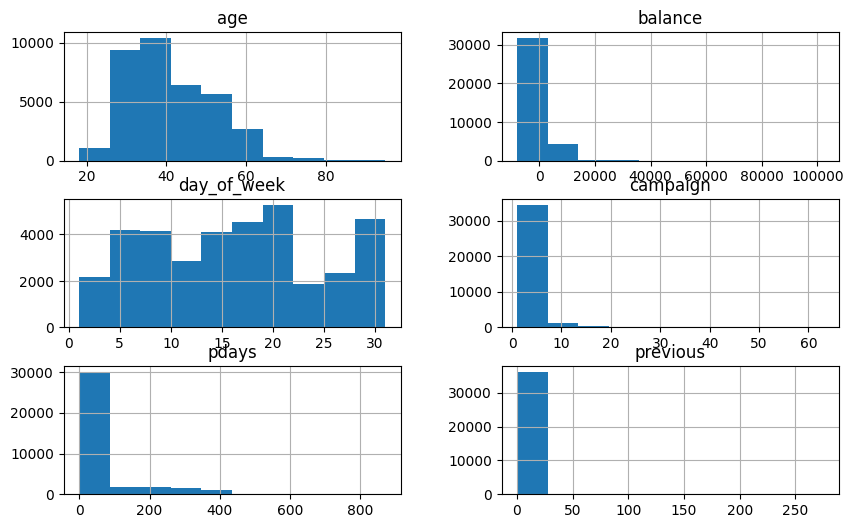

In [12]:
df_full[num].hist(figsize=(10,6))

Most numerical features are skewed, some have extreme outliers. 

#### Look at the value ranges of the categorical features

In [13]:
df_full[cat].nunique()

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
dtype: int64

#### Feature importance analysis 

In [14]:
df_full.y.value_counts(normalize=True)

y
0    0.883934
1    0.116066
Name: proportion, dtype: float64

#### Feature importance analysis: Difference from mean and loan likelihood

In [15]:
from IPython.display import display

global_y = df.y.mean()

for c in cat:
    print(c)
    df_group = df_full.groupby(c).y.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_y
    df_group['likelihood'] = df_group['mean'] / global_y
    display(df_group)
    print()
    print()

job


,mean,count,diff,likelihood
job,,,,
admin.,0.119894,4137,0.002909,1.024865
blue-collar,0.072252,7806,-0.044733,0.617620
entrepreneur,0.086587,1178,-0.030397,0.740160
housemaid,0.093812,1002,-0.023172,0.801919
management,0.135467,7500,0.018482,1.157985
retired,0.222590,1815,0.105605,1.902722
self-employed,0.122862,1286,0.005877,1.050235
services,0.090746,3350,-0.026239,0.775710
student,0.278976,742,0.161991,2.384718




marital


,mean,count,diff,likelihood
marital,,,,
divorced,0.119720,4143,0.002735,1.023381
married,0.100573,21805,-0.016412,0.859712
single,0.147637,10221,0.030652,1.262020




education


,mean,count,diff,likelihood
education,,,,
primary,0.086377,5476,-0.030608,0.738360
secondary,0.105297,18671,-0.011688,0.900091
tertiary,0.148970,10539,0.031986,1.273417
unknown,0.127444,1483,0.010460,1.089410




default


,mean,count,diff,likelihood
default,,,,
no,0.117125,35492,0.000140,1.001198
yes,0.060561,677,-0.056424,0.517685




housing


,mean,count,diff,likelihood
housing,,,,
no,0.166396,16034,0.049412,1.422376
yes,0.075987,20135,-0.040998,0.649547




loan


,mean,count,diff,likelihood
loan,,,,
no,0.125437,30334,0.008452,1.072249
yes,0.067352,5835,-0.049633,0.575734




contact


,mean,count,diff,likelihood
contact,,,,
cellular,0.148270,23464,0.031285,1.267427
telephone,0.137128,2319,0.020143,1.172187
unknown,0.038610,10386,-0.078375,0.330040




month


,mean,count,diff,likelihood
month,,,,
apr,0.202645,2344,0.085660,1.732234
aug,0.110954,4966,-0.006030,0.948452
dec,0.464481,183,0.347496,3.970438
feb,0.156723,2112,0.039739,1.339691
jan,0.098678,1135,-0.018306,0.843515
jul,0.091927,5537,-0.025058,0.785803
jun,0.098865,4319,-0.018119,0.845114
mar,0.516043,374,0.399058,4.411195
may,0.065219,10963,-0.051765,0.557503




poutcome


,mean,count,diff,likelihood
poutcome,,,,
failure,0.126891,3901,0.009906,1.084675
other,0.170341,1497,0.053356,1.456092
success,0.641322,1210,0.524338,5.482099
unknown,0.090389,29561,-0.026595,0.772659


Some of the information displayed here will be useful in the feature engineering section

#### Feature importance: Mutual information score


In [16]:
mi = df_full[cat].apply(lambda col: mutual_info_score(col, df_full.y))
mi.sort_values(ascending=False)

poutcome     0.029257
month        0.024773
contact      0.014166
housing      0.009798
job          0.007765
loan         0.002509
education    0.002458
marital      0.002019
default      0.000339
dtype: float64

#### Feature importance: Correlation

In [17]:
df_full[num].corrwith(df_full.y).abs().sort_values(ascending=False)

pdays          0.105745
previous       0.092053
campaign       0.072568
balance        0.052515
age            0.026687
day_of_week    0.025892
dtype: float64

#### Numerical features colinearity

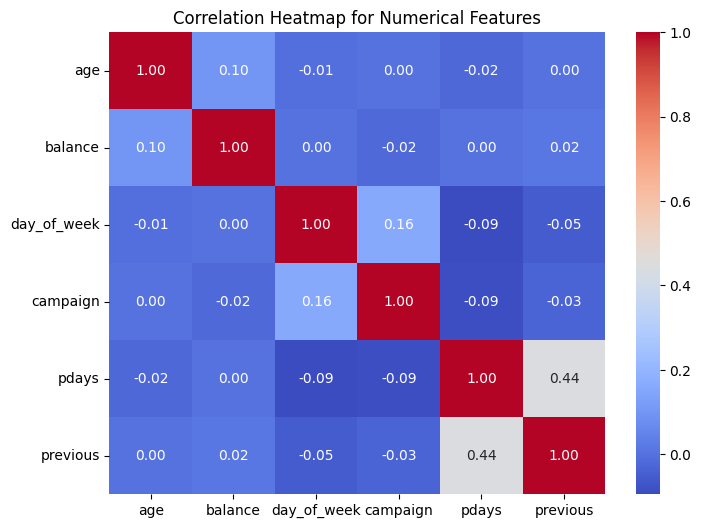

In [18]:
# Calculate the correlation matrix
corr_matrix = df_full[num].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Heatmap for Numerical Features')
plt.show()

### Model definition

* Create models with default parameter values
* Assess the models and select which ones to proceed with

#### Create models with default parameter values

In [19]:
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

models_dict = {
    'Logistic Regression': lr_model,
    'Decision Tree': dt_model,
    'XGBoost': xgb_model
}

/home/minasonbol/Documents/study/mleng-zoomcamp/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Assess the models on training data and select which models to proceed with

In [20]:
# Define a function for model evaluation
def evaluate_model(model, X, y, t):
    y_pred = model.predict_proba(X)[:,1]
    precision = precision_score(y, y_pred >= t, zero_division=0)
    recall = recall_score(y, y_pred >= t)
    f1 = f1_score(y, y_pred >= t, zero_division=0)
    roc_auc = roc_auc_score(y, y_pred >= t)
    return precision, recall, f1, roc_auc

In [21]:
metrics = ('Precision', 'Recall', 'F1-score', 'ROC AUC')

for model in models_dict:
    print(f"Metrics for {model}:")
    scores = evaluate_model(models_dict[model], X_train, y_train, 0.5)
    for metric, score in zip(metrics, scores):
        print(f"{metric}: {score}")
    print("\n")

Metrics for Logistic Regression:
Precision: 0.6721311475409836
Recall: 0.04898446833930705
F1-score: 0.0913140311804009
ROC AUC: 0.5229289403094902


Metrics for Decision Tree:
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC AUC: 1.0


Metrics for XGBoost:
Precision: 0.9053646775165762
Recall: 0.4486260454002389
F1-score: 0.5999600559217096
ROC AUC: 0.7212450584995489




Based on the above values, I'll discard the logistic regression model. Next, I use feature engineering to create a more optimized dataset, then I tune the hyperparameters of the deicision tree and XGBoost models

### Feature Engineering

* Drop categorical features with low mutual information scores
* Filter out rows with balance lower than -1000 and higher than 4000 (little less than 25th percentalie and little more than 75th percentile)
* Drop `day_of_week` feature since it has the lowest correlation score with the target variable
* Convert numerical features to categorical features
* Consolidate categories of categorical features with many categories
* Delete rows with unkonwn poutcomes

#### Drop categorical features with low mutual information scores

In [22]:
num = ['age', 'balance', 'day_of_week', 'campaign', 'pdays', 'previous']
cat = ['job', 'housing', 'contact', 'month', 'poutcome']
features = num + cat
df_filtered =  pd.concat([df_full[features], df_full['y']],axis=1)
df_filtered.head()

,age,balance,day_of_week,campaign,pdays,previous,job,housing,contact,month,poutcome,y
11677,37,2209,20,2,-1,0,technician,no,unknown,jun,unknown,0
3344,41,849,15,1,-1,0,blue-collar,yes,unknown,may,unknown,0
17965,49,1415,30,2,-1,0,technician,yes,cellular,jul,unknown,0
18299,42,3842,31,4,-1,0,admin.,no,cellular,jul,unknown,0
10221,37,-119,11,11,-1,0,management,yes,unknown,jun,unknown,0


#### Filter out rows with balance lower than -1000 and higher than 4000 (little less than 25th percentalie and little more than 75th percentile)
#### Drop `day_of_week` feature since it has the lowest correlation score with the target variable

In [23]:
df_filtered = df_filtered[(df_filtered['balance']>=-1000) & (df_filtered['balance']<=4000)].drop(['day_of_week'], axis=1).copy()

#### Convert numerical features to categorical features

In [24]:
# mapping pdays based on conditions
df_filtered['pdays'] = df_filtered['pdays'].apply(lambda x: 'never' if x == -1 else ('plus 12 months' if x > 365 else ('plus 6 months' if 180 <= x <= 365 else '6 months')))
# mapping previous based on conditions
df_filtered['previous'] = df_filtered['previous'].apply(lambda x: 'never' if x == 0 else ('more than 5' if x > 5 else 'less than 5'))
# mapping campaing based on conditions
df_filtered['campaign'] = df_filtered['campaign'].apply(lambda x: 'once' if x == 1 else 'more than once')

#### Consolidate categories of categorical features with many categories

In [25]:
# List comprehension with if, elif, and else
seasons = {
    'fall': ['sep','oct','nov'],
    'winter': ['dec','jan','feb'],
    'spring': ['mar','apr','may'],
    'summer': ['jun','jul','aug']
}

df_filtered['season'] = [season[0] for mon in df_filtered['month'] for season in list(seasons.items()) if mon in season[1]]

In [26]:
job_category = {
    'cat_1': ['blue-collar','entrepreneur','housemaid'],
    'cat_2': ['retired','student','unemployed'],
    'cat_3': ['technician', 'admin.', 'management', 'services','unknown', 'self-employed']
}

df_filtered['job_category'] = [category[0] for job in df_filtered['job'] for category in list(job_category.items()) if job in category[1]]

In [27]:
df_filtered = df_filtered.drop(['month','job'], axis=1).copy()

In [28]:
df_filtered['contact'] = ['no' if contact == 'unknown' else 'yes' for contact in df_filtered['contact']]

#### Delete most rows with unkonwn poutcomes, keep only 1000

In [29]:
df_filtered = pd.concat([df_filtered[df_filtered['poutcome'] != 'unknown'], df_filtered[df_filtered['poutcome'] == 'unknown'].head(1000)]).sample(frac=1).reset_index(drop=True)
df_filtered['poutcome'] = [outcome if outcome in ['success', 'failure'] else 'other' for outcome in df_filtered['poutcome']]

### Tuning hyperparameters of Decision Tree and XGBoost models

#### Decision trees

In [30]:
thresholds = np.linspace(0, 1, 5)

# Set up the parameter grid
param_grid = {
    'max_depth':[1, 2, 3, 5, 10],
    'min_samples_leaf': [1, 5, 10, 15, 20]
}

dt_scores = []

for t in thresholds:
    for depth in param_grid['max_depth']:
        for samples_leaf in param_grid['min_samples_leaf']:

            # Set up KFold cross-validation
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            fold_precision_scores = []
            fold_recall_scores = []
            fold_f1_scores = []
            fold_auc_scores = []

            for train_idx, val_idx in kf.split(df_filtered):
                df_train = df_filtered.iloc[train_idx]
                df_val = df_filtered.iloc[val_idx]

                y_train = df_train.y.values
                y_val = df_val.y.values

                del df_train['y']
                del df_val['y']

                df_train=df_train.to_dict(orient='records')
                df_val=df_val.to_dict(orient='records')

                dv = DictVectorizer(sparse=False)
                dv.fit(df_train)

                X_train = dv.transform(df_train)
                X_val = dv.transform(df_val)

                # Create the model
                dt_model = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=samples_leaf, random_state=42)
                dt_model.fit(X_train, y_train)

                precision, recall, f1, auc = evaluate_model(dt_model, X_val, y_val, t)

                fold_precision_scores.append(precision)
                fold_recall_scores.append(recall)
                fold_f1_scores.append(f1)
                fold_auc_scores.append(auc)

            print('t=%s, depth=%s, samples_leaf=%s, precision=%.3f +- %.3f, recall=%.3f +- %.3f, f1=%.3f +- %.3f, auc=%.3f +- %.3f' % (t, depth, samples_leaf, np.mean(fold_precision_scores), np.std(fold_precision_scores), np.mean(fold_recall_scores), np.std(fold_recall_scores),np.mean(fold_f1_scores), np.std(fold_f1_scores),np.mean(fold_auc_scores), np.std(fold_auc_scores)))
            dt_scores.append(list([{'t':t, 'max_depth':depth, 'min_samples_leaf':samples_leaf}, np.mean(fold_precision_scores), np.mean(fold_recall_scores), np.mean(fold_f1_scores), np.mean(fold_auc_scores), (dv, dt_model)]))

t=0.0, depth=1, samples_leaf=1, precision=0.206 +- 0.012, recall=1.000 +- 0.000, f1=0.342 +- 0.017, auc=0.500 +- 0.000
t=0.0, depth=1, samples_leaf=5, precision=0.206 +- 0.012, recall=1.000 +- 0.000, f1=0.342 +- 0.017, auc=0.500 +- 0.000
t=0.0, depth=1, samples_leaf=10, precision=0.206 +- 0.012, recall=1.000 +- 0.000, f1=0.342 +- 0.017, auc=0.500 +- 0.000
t=0.0, depth=1, samples_leaf=15, precision=0.206 +- 0.012, recall=1.000 +- 0.000, f1=0.342 +- 0.017, auc=0.500 +- 0.000
t=0.0, depth=1, samples_leaf=20, precision=0.206 +- 0.012, recall=1.000 +- 0.000, f1=0.342 +- 0.017, auc=0.500 +- 0.000
t=0.0, depth=2, samples_leaf=1, precision=0.206 +- 0.012, recall=1.000 +- 0.000, f1=0.342 +- 0.017, auc=0.500 +- 0.000
t=0.0, depth=2, samples_leaf=5, precision=0.206 +- 0.012, recall=1.000 +- 0.000, f1=0.342 +- 0.017, auc=0.500 +- 0.000
t=0.0, depth=2, samples_leaf=10, precision=0.206 +- 0.012, recall=1.000 +- 0.000, f1=0.342 +- 0.017, auc=0.500 +- 0.000
t=0.0, depth=2, samples_leaf=15, precision=0

#### XGBoost

In [31]:
thresholds = np.linspace(0, 1, 5)

# Set up the parameter grid
param_grid = {
    'eta': [0.1, 0.3, 0.5],
    'max_depth': [1, 2, 3],
    'min_child_weight': [1, 2, 4]
}

xgb_scores = []

for t in thresholds:
    for eta in param_grid['eta']:
        for depth in param_grid['max_depth']:
            for child_weight in param_grid['min_child_weight']:
                
                # Set up KFold cross-validation
                kf = KFold(n_splits=5, shuffle=True, random_state=42)
                fold_precision_scores = []
                fold_recall_scores = []
                fold_f1_scores = []
                fold_auc_scores = []
    
                for train_idx, val_idx in kf.split(df_filtered):
                    df_train = df_filtered.iloc[train_idx]
                    df_val = df_filtered.iloc[val_idx]
                    
                    y_train = df_train.y.values
                    y_val = df_val.y.values
    
                    del df_train['y']
                    del df_val['y']
    
                    df_train=df_train.to_dict(orient='records')
                    df_val=df_val.to_dict(orient='records')
                    
                    dv = DictVectorizer(sparse=False)
                    dv.fit(df_train)
                    
                    X_train = dv.transform(df_train)
                    X_val = dv.transform(df_val)
    
                    # Create the model
                    xgb_model = xgb.XGBClassifier(eta=eta, max_depth=depth, min_child_weight=child_weight, objective='binary:logistic', eval_metric='auc', random_state=42)        
                    xgb_model.fit(X_train, y_train)
    
                    y_pred = xgb_model.predict(X_val)
    
                    precision, recall, f1, auc = evaluate_model(xgb_model, X_val, y_val, t)
                    
                    fold_precision_scores.append(precision)
                    fold_recall_scores.append(recall)
                    fold_f1_scores.append(f1)
                    fold_auc_scores.append(auc)
    
                print('t=%s, eta=%s, depth=%s, child_weight=%s, precision=%.3f +- %.3f, recall=%.3f +- %.3f, f1=%.3f +- %.3f, auc=%.3f +- %.3f' % (t, eta, depth, child_weight, np.mean(fold_precision_scores), np.std(fold_precision_scores), np.mean(fold_recall_scores), np.std(fold_recall_scores),np.mean(fold_f1_scores), np.std(fold_f1_scores),np.mean(fold_auc_scores), np.std(fold_auc_scores)))
                xgb_scores.append(list([{'t':t, 'eta':eta, 'max_depth':depth, 'min_child_weight':child_weight}, np.mean(fold_precision_scores), np.mean(fold_recall_scores), np.mean(fold_f1_scores), np.mean(fold_auc_scores), (dv, xgb_model)]))

t=0.0, eta=0.1, depth=1, child_weight=1, precision=0.206 +- 0.012, recall=1.000 +- 0.000, f1=0.342 +- 0.017, auc=0.500 +- 0.000
t=0.0, eta=0.1, depth=1, child_weight=2, precision=0.206 +- 0.012, recall=1.000 +- 0.000, f1=0.342 +- 0.017, auc=0.500 +- 0.000
t=0.0, eta=0.1, depth=1, child_weight=4, precision=0.206 +- 0.012, recall=1.000 +- 0.000, f1=0.342 +- 0.017, auc=0.500 +- 0.000
t=0.0, eta=0.1, depth=2, child_weight=1, precision=0.206 +- 0.012, recall=1.000 +- 0.000, f1=0.342 +- 0.017, auc=0.500 +- 0.000
t=0.0, eta=0.1, depth=2, child_weight=2, precision=0.206 +- 0.012, recall=1.000 +- 0.000, f1=0.342 +- 0.017, auc=0.500 +- 0.000
t=0.0, eta=0.1, depth=2, child_weight=4, precision=0.206 +- 0.012, recall=1.000 +- 0.000, f1=0.342 +- 0.017, auc=0.500 +- 0.000
t=0.0, eta=0.1, depth=3, child_weight=1, precision=0.206 +- 0.012, recall=1.000 +- 0.000, f1=0.342 +- 0.017, auc=0.500 +- 0.000
t=0.0, eta=0.1, depth=3, child_weight=2, precision=0.206 +- 0.012, recall=1.000 +- 0.000, f1=0.342 +- 0.

In [32]:
columns = ['parameters', 'precision', 'recall', 'f1', 'auc', 'dv & model'] 
df_dt_scores = pd.DataFrame(dt_scores, columns=columns)
df_xgb_scores = pd.DataFrame(xgb_scores, columns=columns)

In [33]:
df_dt_scores.sort_values(['auc', 'f1'], ascending=False).head()

,parameters,precision,recall,f1,auc,dv & model
44,"{'t': 0.25, 'max_depth': 5, 'min_samples_leaf'...",0.512278,0.631543,0.561063,0.735629,"(DictVectorizer(sparse=False), DecisionTreeCla..."
40,"{'t': 0.25, 'max_depth': 5, 'min_samples_leaf'...",0.509623,0.633727,0.559977,0.735463,"(DictVectorizer(sparse=False), DecisionTreeCla..."
41,"{'t': 0.25, 'max_depth': 5, 'min_samples_leaf'...",0.508161,0.633090,0.558728,0.734784,"(DictVectorizer(sparse=False), DecisionTreeCla..."
43,"{'t': 0.25, 'max_depth': 5, 'min_samples_leaf'...",0.507664,0.632258,0.558694,0.734548,"(DictVectorizer(sparse=False), DecisionTreeCla..."
42,"{'t': 0.25, 'max_depth': 5, 'min_samples_leaf'...",0.508092,0.628717,0.557361,0.733319,"(DictVectorizer(sparse=False), DecisionTreeCla..."


In [34]:
df_xgb_scores.sort_values(['auc', 'f1'], ascending=False).head()

,parameters,precision,recall,f1,auc,dv & model
42,"{'t': 0.25, 'eta': 0.3, 'max_depth': 3, 'min_c...",0.522968,0.657004,0.581537,0.750448,"(DictVectorizer(sparse=False), XGBClassifier(b..."
43,"{'t': 0.25, 'eta': 0.3, 'max_depth': 3, 'min_c...",0.519757,0.658843,0.580409,0.750173,"(DictVectorizer(sparse=False), XGBClassifier(b..."
35,"{'t': 0.25, 'eta': 0.1, 'max_depth': 3, 'min_c...",0.520430,0.656490,0.579943,0.749557,"(DictVectorizer(sparse=False), XGBClassifier(b..."
49,"{'t': 0.25, 'eta': 0.5, 'max_depth': 2, 'min_c...",0.525271,0.652553,0.581385,0.749541,"(DictVectorizer(sparse=False), XGBClassifier(b..."
33,"{'t': 0.25, 'eta': 0.1, 'max_depth': 3, 'min_c...",0.522904,0.654407,0.580614,0.749510,"(DictVectorizer(sparse=False), XGBClassifier(b..."


In [35]:
df_dt_scores['model'] = 'decision tree'
df_xgb_scores['model'] = 'xgboost'

In [36]:
df_scores = pd.concat([df_dt_scores, df_xgb_scores]).reset_index()
df_scores = df_scores[['model', 'parameters', 'precision', 'recall', 'f1', 'auc', 'dv & model']]
df_scores.sort_values(['auc', 'f1', 'recall'], ascending=False).head()

,model,parameters,precision,recall,f1,auc,dv & model
167,xgboost,"{'t': 0.25, 'eta': 0.3, 'max_depth': 3, 'min_c...",0.522968,0.657004,0.581537,0.750448,"(DictVectorizer(sparse=False), XGBClassifier(b..."
168,xgboost,"{'t': 0.25, 'eta': 0.3, 'max_depth': 3, 'min_c...",0.519757,0.658843,0.580409,0.750173,"(DictVectorizer(sparse=False), XGBClassifier(b..."
160,xgboost,"{'t': 0.25, 'eta': 0.1, 'max_depth': 3, 'min_c...",0.520430,0.656490,0.579943,0.749557,"(DictVectorizer(sparse=False), XGBClassifier(b..."
174,xgboost,"{'t': 0.25, 'eta': 0.5, 'max_depth': 2, 'min_c...",0.525271,0.652553,0.581385,0.749541,"(DictVectorizer(sparse=False), XGBClassifier(b..."
158,xgboost,"{'t': 0.25, 'eta': 0.1, 'max_depth': 3, 'min_c...",0.522904,0.654407,0.580614,0.749510,"(DictVectorizer(sparse=False), XGBClassifier(b..."


### Assess on test data

In [37]:
def transform_data(df=pd.DataFrame()):
    num = ['age', 'balance', 'day_of_week', 'campaign', 'pdays', 'previous']
    cat = ['job', 'housing', 'contact', 'month', 'poutcome']
    features = num + cat
    df_transformed =  df[features].copy()

    # mapping pdays based on conditions
    df_transformed['pdays'] = df_transformed['pdays'].apply(lambda x: 'never' if x == -1 else ('plus 12 months' if x > 365 else ('plus 6 months' if 180 <= x <= 365 else '6 months')))
    # mapping previous based on conditions
    df_transformed['previous'] = df_transformed['previous'].apply(lambda x: 'never' if x == 0 else ('more than 5' if x > 5 else 'less than 5'))
    # mapping campaing based on conditions
    df_transformed['campaign'] = df_transformed['campaign'].apply(lambda x: 'once' if x == 1 else 'more than once')

    # Consolidate categories of categorical features with many categories
    seasons = {
        'fall': ['sep','oct','nov'],
        'winter': ['dec','jan','feb'],
        'spring': ['mar','apr','may'],
        'summer': ['jun','jul','aug']
    }

    df_transformed['season'] = [season[0] for mon in df_transformed['month'] for season in list(seasons.items()) if mon in season[1]]
    
    job_category = {
        'cat_1': ['blue-collar','entrepreneur','housemaid'],
        'cat_2': ['retired','student','unemployed'],
        'cat_3': ['technician', 'admin.', 'management', 'services','unknown', 'self-employed']
    }

    df_transformed['job_category'] = [category[0] for job in df_transformed['job'] for category in list(job_category.items()) if job in category[1]]
    df_transformed = df_transformed.drop(['month','job'], axis=1).copy()
    df_transformed['contact'] = ['no' if contact == 'unknown' else 'yes' for contact in df_transformed['contact']]

    df_transformed['poutcome'] = [outcome if outcome in ['success', 'failure'] else 'other' for outcome in df_transformed['poutcome']]

    return df_transformed.to_dict(orient='records')

In [45]:
dv, model = df_scores.sort_values(['auc', 'f1', 'recall'], ascending=False).head(1)['dv & model'].values[0]

In [39]:
df_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,campaign,pdays,previous,poutcome,y
3776,40,blue-collar,married,secondary,no,580,yes,no,unknown,16,may,1,-1,0,unknown,0
9928,47,services,single,secondary,no,3644,no,no,unknown,9,jun,2,-1,0,unknown,0
33409,25,student,single,tertiary,no,538,yes,no,cellular,20,apr,1,-1,0,unknown,0
31885,42,management,married,tertiary,no,1773,no,no,cellular,9,apr,1,336,1,failure,0
15738,56,management,married,tertiary,no,217,no,yes,cellular,21,jul,2,-1,0,unknown,0


In [40]:
data_transformer = transform_data

In [46]:
X_test = dv.transform(data_transformer(df_test))
y_test = df_test.y.values

In [47]:
evaluate_model(model, X_test, y_test, 0.25)

(0.40488841657810837, 0.34922089825847846, 0.375, 0.6393947529903888)

In [48]:
confusion_matrix(y_test, model.predict_proba(X_test)[:,1]>=0.25)

array([[7391,  560],
       [ 710,  381]])

In [49]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric='auc',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)